In [1]:
from collections import Counter
from qiskit.converters import circuit_to_dag

def circuit_report(qc):
    ops = qc.count_ops()
    n_2q_by_arity = sum(1 for inst, qargs, cargs in qc.data if inst.num_qubits == 2)
    
    dag = circuit_to_dag(qc)
    n_active = qc.num_qubits - len(list(dag.idle_wires()))

    return {
        "num_qubits": qc.num_qubits,
        "num_of_used_qubits": n_active,
        "depth": qc.depth(),
        "size": qc.size(),
        "ops_by_name": dict(ops),
        "two_qubit_ops_by_arity": n_2q_by_arity,
        "swap_count": ops.get("swap", 0),
        "measure_count": ops.get("measure", 0),
        "reset_count": ops.get("reset", 0),
        "delay_count": ops.get("delay", 0),
    }


In [2]:
num_of_lamps = 4
search_space_qubits = 2
helper_qubits = num_of_lamps - 1
number_of_iterations = 1

{'11': 10000}
32


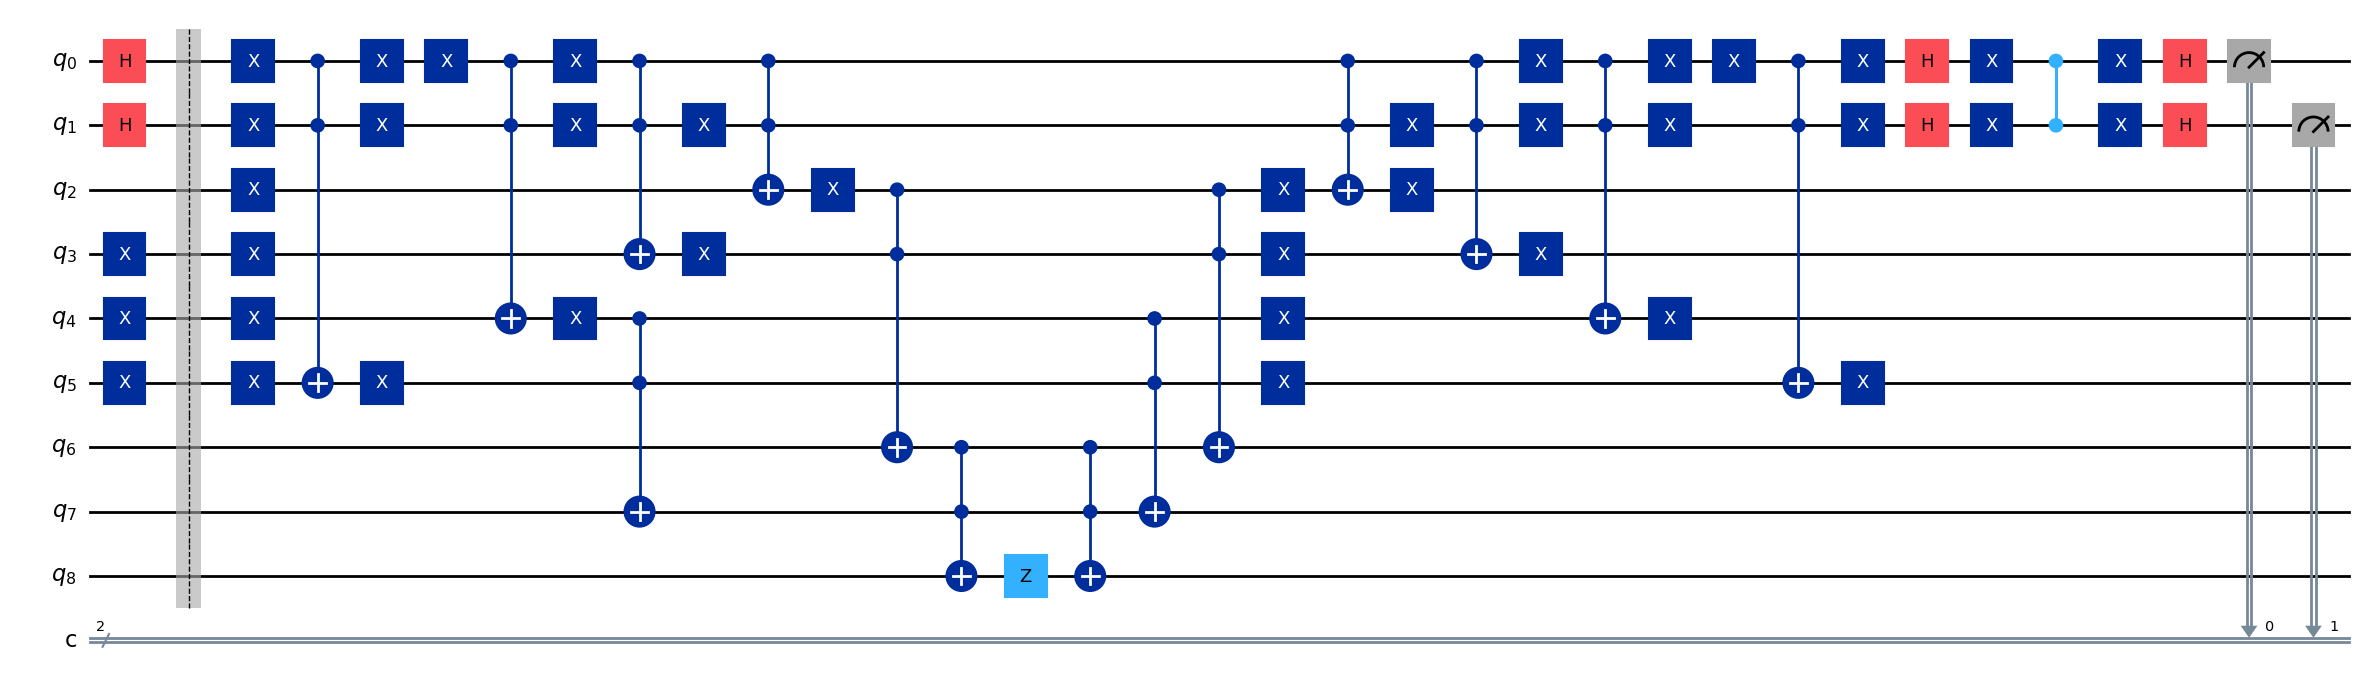

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from math import pi

oracle = QuantumCircuit(search_space_qubits + num_of_lamps + helper_qubits)

for i in range(num_of_lamps):
    oracle.x(search_space_qubits + i)

oracle.x(0)
oracle.x(1)
oracle.ccx(0,1,search_space_qubits+3)
oracle.x(0)
oracle.x(1)

oracle.x(0)
oracle.ccx(0,1,search_space_qubits+2)
oracle.x(0)

oracle.x(1)
oracle.ccx(0,1,search_space_qubits+1)
oracle.x(1)

oracle.ccx(0,1,search_space_qubits)

for i in range(num_of_lamps):
    oracle.x(search_space_qubits + i)

oracle.ccx(search_space_qubits, search_space_qubits+1, search_space_qubits + num_of_lamps)
oracle.ccx(search_space_qubits+2, search_space_qubits+3, search_space_qubits + num_of_lamps + 1)
oracle.ccx(search_space_qubits + num_of_lamps, search_space_qubits + num_of_lamps + 1, search_space_qubits + num_of_lamps + 2)
oracle.z(search_space_qubits + num_of_lamps + 2)
oracle.ccx(search_space_qubits + num_of_lamps, search_space_qubits + num_of_lamps + 1, search_space_qubits + num_of_lamps + 2)
oracle.ccx(search_space_qubits+2, search_space_qubits+3, search_space_qubits + num_of_lamps + 1)
oracle.ccx(search_space_qubits, search_space_qubits+1, search_space_qubits + num_of_lamps)

for i in range(num_of_lamps):
    oracle.x(search_space_qubits + i)

oracle.ccx(0,1,search_space_qubits)

oracle.x(1)
oracle.ccx(0,1,search_space_qubits+1)
oracle.x(1)

oracle.x(0)
oracle.ccx(0,1,search_space_qubits+2)
oracle.x(0)

oracle.x(0)
oracle.x(1)
oracle.ccx(0,1,search_space_qubits+3)
oracle.x(0)
oracle.x(1)

for i in range(num_of_lamps):
    oracle.x(search_space_qubits + i)

grover = QuantumCircuit(search_space_qubits + num_of_lamps + helper_qubits, search_space_qubits)

#Input
grover.x(search_space_qubits+1)
grover.x(search_space_qubits+2)
grover.x(search_space_qubits+3)

for i in range(search_space_qubits):
    grover.h(i)
grover.barrier()

for i in range(number_of_iterations):
    grover = grover.compose(oracle)
    
    for j in range(search_space_qubits):
        grover.h(j)
    for j in range(search_space_qubits):
        grover.x(j)
    grover.cz(0,1)
    for j in range(search_space_qubits):
        grover.x(j)
    for j in range(search_space_qubits):
        grover.h(j)

grover.measure(range(search_space_qubits),range(search_space_qubits))

job = AerSimulator().run(grover,shots=10000)
counts = job.result().get_counts(grover)
print(counts)

print(grover.depth())
grover.draw(output='mpl', fold=50)

In [4]:
import os
from qiskit import transpile
from iqm.qiskit_iqm import IQMProvider

os.environ["IQM_TOKEN"] = "TOKEN"

RESONANCE_URL = "https://resonance.meetiqm.com"

def get_backend(device: str, calibration_set_id=None, use_metrics=True):
    provider = IQMProvider(
        RESONANCE_URL,
        quantum_computer=device#,      # "garnet", "emerald", "sirius"
    )
    return provider.get_backend(
        calibration_set_id=calibration_set_id,
        use_metrics=use_metrics,
    )

backend_garnet  = get_backend("garnet")

C:\Users\user\anaconda3\envs\iqm_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>optimization_level = 3</h3>

In [5]:
transpiled = transpile(grover, backend=backend_garnet, optimization_level=3)
print(circuit_report(transpiled))

{'num_qubits': 20, 'num_of_used_qubits': 9, 'depth': 232, 'size': 402, 'ops_by_name': {'r': 249, 'cz': 151, 'measure': 2, 'barrier': 1}, 'two_qubit_ops_by_arity': 151, 'swap_count': 0, 'measure_count': 2, 'reset_count': 0, 'delay_count': 0}


C:\Users\user\AppData\Local\Temp\ipykernel_15232\1478029584.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  n_2q_by_arity = sum(1 for inst, qargs, cargs in qc.data if inst.num_qubits == 2)


Progress in queue:   0%|                                                                         | 0/1 [00:04<?, ?it/s]


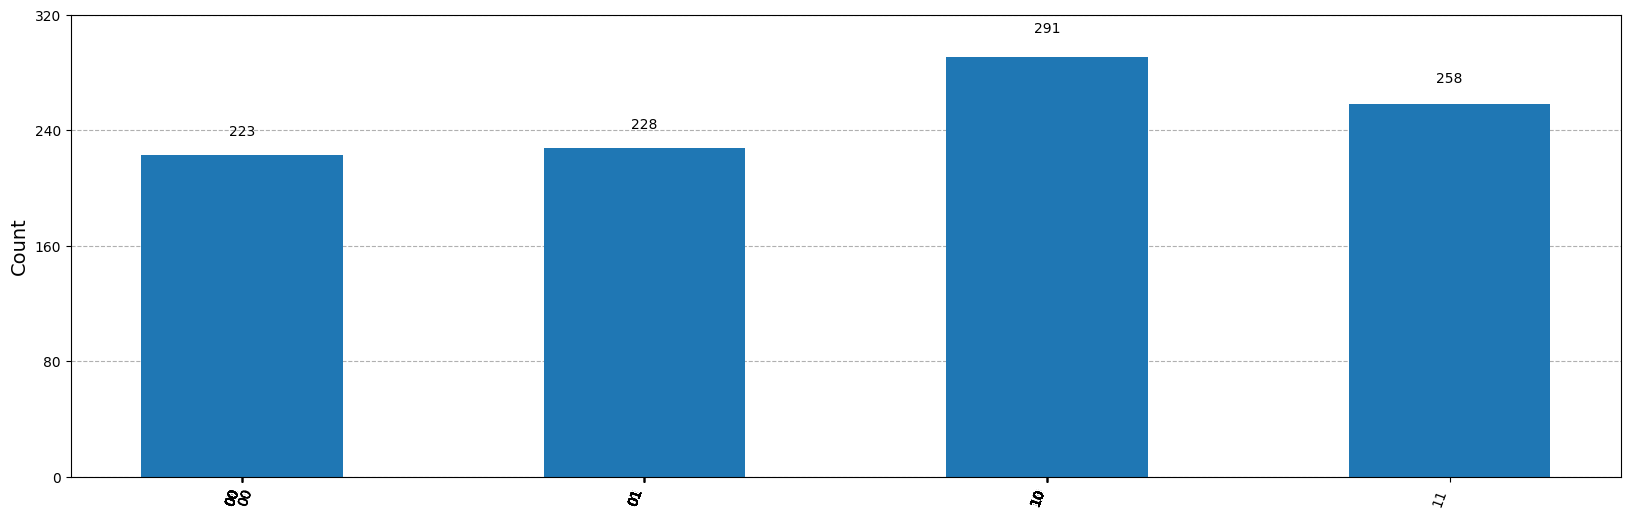

In [6]:
job = backend_garnet.run(transpiled, shots=1000)

import qiskit
if qiskit.__version__ < '1.0.0':
    # The job monitor is only compatible with qiskit versions smaller than 1.0
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)

res=job.result()
counts=res.get_counts()

#Plot the results
from qiskit.visualization import plot_histogram
import numpy as np

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()

<h3>optimization_level = 2</h3>

In [7]:
transpiled = transpile(grover, backend=backend_garnet, optimization_level=2)
print(circuit_report(transpiled))

{'num_qubits': 20, 'num_of_used_qubits': 9, 'depth': 227, 'size': 397, 'ops_by_name': {'r': 250, 'cz': 145, 'measure': 2, 'barrier': 1}, 'two_qubit_ops_by_arity': 145, 'swap_count': 0, 'measure_count': 2, 'reset_count': 0, 'delay_count': 0}


C:\Users\user\AppData\Local\Temp\ipykernel_15232\1478029584.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  n_2q_by_arity = sum(1 for inst, qargs, cargs in qc.data if inst.num_qubits == 2)


Progress in queue:   0%|                                                                         | 0/1 [00:01<?, ?it/s]


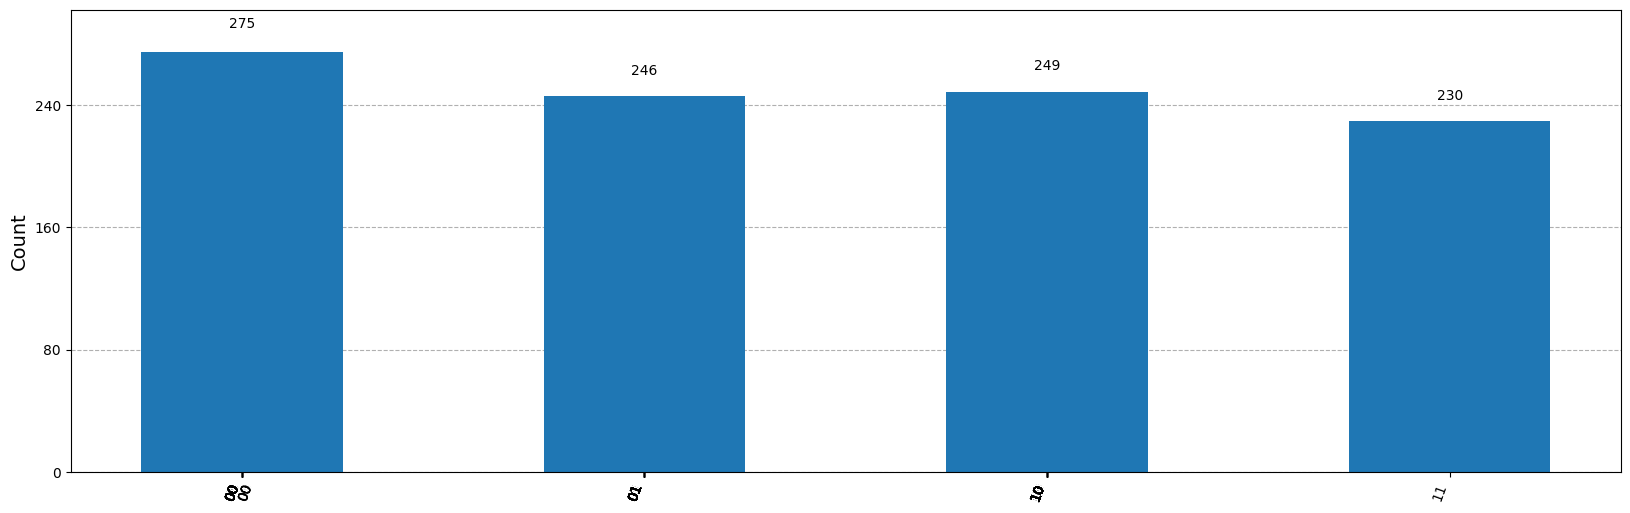

In [8]:
job = backend_garnet.run(transpiled, shots=1000)

import qiskit
if qiskit.__version__ < '1.0.0':
    # The job monitor is only compatible with qiskit versions smaller than 1.0
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)

res=job.result()
counts=res.get_counts()

#Plot the results
from qiskit.visualization import plot_histogram
import numpy as np

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()

<h3>optimization_level = 1</h3>

In [9]:
transpiled = transpile(grover, backend=backend_garnet, optimization_level=1)
print(circuit_report(transpiled))

{'num_qubits': 20, 'num_of_used_qubits': 10, 'depth': 257, 'size': 454, 'ops_by_name': {'r': 274, 'cz': 178, 'measure': 2, 'barrier': 1}, 'two_qubit_ops_by_arity': 178, 'swap_count': 0, 'measure_count': 2, 'reset_count': 0, 'delay_count': 0}


C:\Users\user\AppData\Local\Temp\ipykernel_15232\1478029584.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  n_2q_by_arity = sum(1 for inst, qargs, cargs in qc.data if inst.num_qubits == 2)


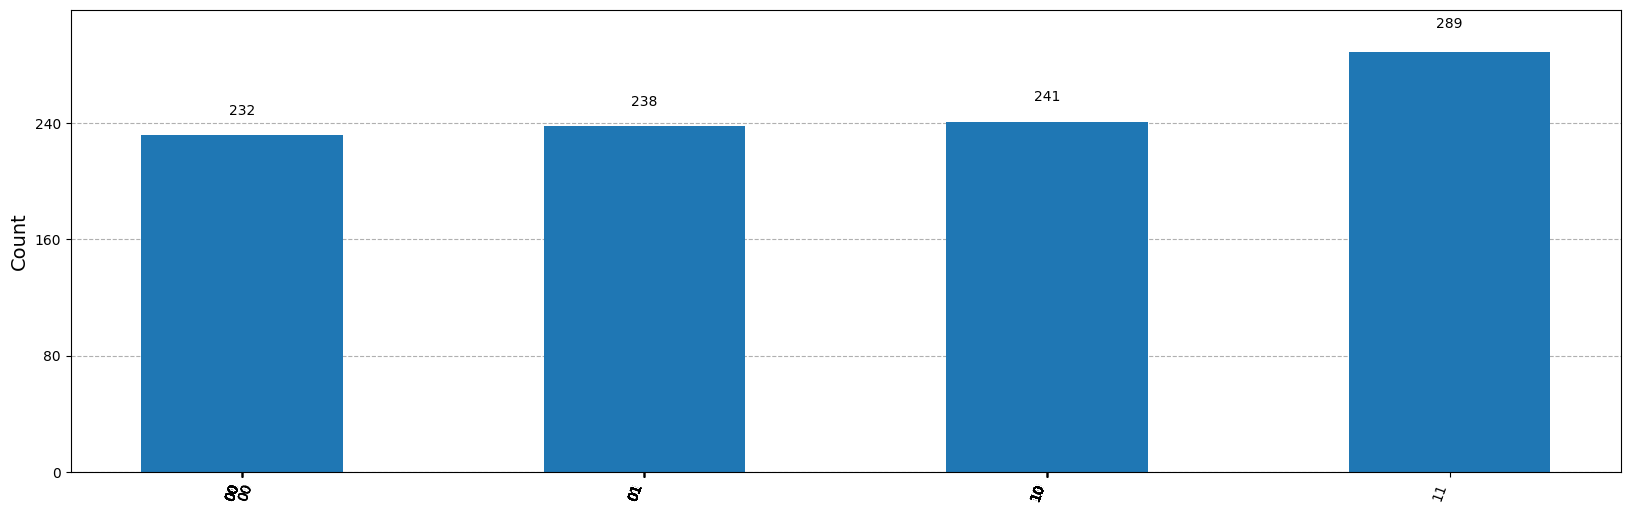

In [10]:
job = backend_garnet.run(transpiled, shots=1000)

import qiskit
if qiskit.__version__ < '1.0.0':
    # The job monitor is only compatible with qiskit versions smaller than 1.0
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)

res=job.result()
counts=res.get_counts()

#Plot the results
from qiskit.visualization import plot_histogram
import numpy as np

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()

<h3>optimization_level = 0</h3>

In [11]:
transpiled = transpile(grover, backend=backend_garnet, optimization_level=0)
print(circuit_report(transpiled))

TranspilerError: 'The circuit has an invalid layout as two qubits need to interact in disconnected components of the coupling map. The physical qubit 2 needs to interact with the qubit 1 and they belong to different components'

In [12]:
transpiled = transpile(grover, backend=backend_garnet, optimization_level=0, layout_method="dense", routing_method="sabre",)
print(circuit_report(transpiled))

{'num_qubits': 20, 'num_of_used_qubits': 9, 'depth': 694, 'size': 1204, 'ops_by_name': {'r': 991, 'cz': 211, 'measure': 2, 'barrier': 1}, 'two_qubit_ops_by_arity': 211, 'swap_count': 0, 'measure_count': 2, 'reset_count': 0, 'delay_count': 0}


C:\Users\user\AppData\Local\Temp\ipykernel_15232\1478029584.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  n_2q_by_arity = sum(1 for inst, qargs, cargs in qc.data if inst.num_qubits == 2)


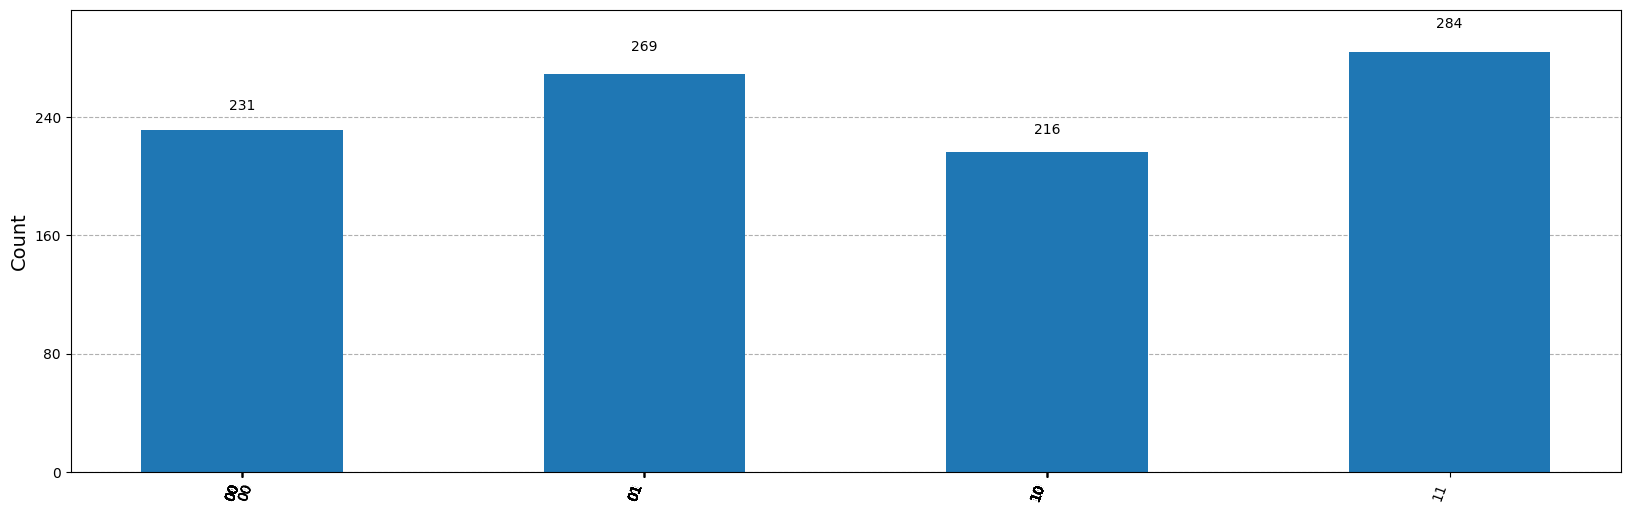

In [13]:
job = backend_garnet.run(transpiled, shots=1000)

import qiskit
if qiskit.__version__ < '1.0.0':
    # The job monitor is only compatible with qiskit versions smaller than 1.0
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)

res=job.result()
counts=res.get_counts()

#Plot the results
from qiskit.visualization import plot_histogram
import numpy as np

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()